In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
#from epftoolbox.evaluation import MASE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

import warnings

from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.kernel_approximation import Nystroem

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

    
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - MASE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_forecast = np.roll(y_true, shift=1)  # Naïve forecast: previous value as the next
    naive_forecast[0] = y_true[0]  # First value remains the same to avoid shifting issues
    naive_mae = np.mean(np.abs(y_true - naive_forecast))  # Baseline error
    mase = np.mean(np.abs(y_true - y_pred)) / naive_mae if naive_mae != 0 else np.nan  # Avoid division by zero
    return mase


def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    #rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    #mae_scaled = mean_absolute_error(y_true, y_pred)
    
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = y_true
    y_pred_original = y_pred
    epsilon=1e-8
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    mase_original = mean_absolute_scaled_error(y_true_original , y_pred_original) 
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original, mase_original

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_residual_analysis(y_true_scaled, predictions_scaled, target_scaler, title_prefix="Train"):
    """
    Plots residuals vs time and histogram of residuals using original-scale targets.

    Parameters:
    - y_true_scaled: Scaled true target values.
    - predictions_scaled: Scaled predicted target values.
    - target_scaler: Scaler used to inverse-transform scaled predictions.
    - title_prefix: Prefix for plot titles (e.g., 'Train' or 'Test').
    """
    # Inverse-transform scaled values to original scale
    y_true = target_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

    # Calculate residuals in original scale
    residuals = y_true - predictions

    # Create a 1x2 plot (Removing ACF plot)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{title_prefix} Residual Analysis (Original Scale)', fontsize=16)

    # 1. Residuals vs Time
    axes[0].plot(residuals, marker='o', linestyle='none', alpha=0.7)
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Residuals vs Time')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Residuals (Original Scale)')

    # 2. Histogram of Residuals
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color='skyblue')
    axes[1].set_title('Histogram of Residuals')
    axes[1].set_xlabel('Residuals (Original Scale)')
    axes[1].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [4]:
# Step 1: Split the data
def split_data(data, max_lag, windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns, SMA features.
    Uses a unified 'windows' parameter for both SMA.
    """
    # Add seasonality features
    data['Month'] = data.index.month
    data['Weekday'] = data.index.weekday
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features 
    for window in windows:
        data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


    # Drop rows with NaN values due to lagging and SMA calculation
    data = data.dropna()

    # Extract feature columns
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in windows] + \
                      [ 'Month', 'Weekday', 'Quarter', 'WeekOfYear']
    
    # Extract features and target
    X = data[feature_columns].values
    y = data['Log_Return'].values

    # Create polynomial features
    poly_degree = 2
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Identify indices of original features in X_poly
    feature_names = poly.get_feature_names_out()
    original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_columns]
    
    # Extract original features from X_poly
    X_poly_original = X_poly[:, original_feature_indices]
    
    # Extract interaction terms (residuals)
    X_poly_residual = np.delete(X_poly, original_feature_indices, axis=1)

    # Apply Truncated SVD for dimensionality reduction
    svd_components = 100
    svd = TruncatedSVD(n_components=svd_components, random_state=42)
    X_svd = svd.fit_transform(X_poly_residual)

    # Combine original + SVD features
    X_combined = np.concatenate([X_poly_original, X_svd], axis=1)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.75)
    X_train, X_test = X_combined[:train_size], X_combined[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, poly, svd, feature_columns

# Step 2: Scale the data

def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Step 3: Model training with hyperparameter tuning using LassoCV
# Step 3: Model training with hyperparameter tuning using LassoCV
def model_training(train_data_scaled, y_train_scaled):


# Initialize LassoCV with a predefined number of alphas and other parameters
    lasso_cv = LassoCV(
        n_alphas=500, 
        cv=5,  
        random_state=42  
    )

    # Define the hyperparameter space for Bayesian optimization excluding alpha and n_alphas
    param_space = {
        'eps': Real(1e-4, 1e-1, prior='log-uniform'),  
        'fit_intercept': Categorical([True, False]),
        'precompute': Categorical(['auto', True, False]),
        'max_iter': Integer(1000, 4000),
        'tol': Real(1e-4, 1e-2, prior='log-uniform')  
    }

    # Use BayesSearchCV to find the best combination of hyperparameters
    bayes_search = BayesSearchCV(
        estimator=lasso_cv,
        search_spaces=param_space,
        n_iter=30,
        cv=5,  # Number of cross-validation folds for hyperparameter optimization
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_points=15
    )

    # Fit the model
    #bayes_search.fit(train_data_scaled, y_train)
    bayes_search.fit(train_data_scaled, y_train_scaled.ravel())

    # Get the best model and parameters
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    # Display the best model parameters
    print("Best Model Parameters:")
    print(best_params)

    return best_model, best_params



# Step 7: Main Function

def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, best_params):
    X_full, _, y_full, _, _, _, _= split_data(data, max_lag,sma_windows, "2000-01-01", "2023-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))

    #  Check if `best_params` are properly set
    if best_params is None:
        raise ValueError("Error: No best parameters found for final model training.")

    #  Train LassoCV using the best hyperparameters
    final_model = LassoCV(
        eps=best_params['eps'],
        fit_intercept=best_params['fit_intercept'],
        precompute=best_params['precompute'],
        max_iter=best_params['max_iter'],
        tol=best_params['tol'],
        cv=10,
        random_state=42
    ).fit(X_full_scaled, y_full_scaled.ravel())

    #  Ensure the model is trained properly
    if final_model is None:
        raise ValueError("Final model training failed!")

    return final_model  # Must return the trained model


In [5]:
def forecast_future(data, model, x_scaler, y_scaler, poly, svd, feature_cols, max_lag, windows, start_date="2024-01-01", end_date="2024-12-31"):
    """Forecast future log returns using the trained model with lagged returns, SMA."""
    if model is None:
        raise ValueError("Cannot forecast because the model is not trained.")
    
    # Prepare 3-year rolling window for quantile calculation
    three_year_window = 756  # Approx. 3 years of trading days (252 days per year)
    historical_log_returns = data['Log_Return'].tail(three_year_window).tolist()


    # Extract and scale the latest lagged, SMA
    lagged_features = np.array([data['Log_Return'].iloc[-i] for i in range(1, max_lag + 1)])
    sma_features = np.array([data['Log_Return'].iloc[-window:].mean() for window in windows])
    
    future_dates = pd.date_range(start=start_date, end=end_date, freq="B")
    future_forecasts = pd.DataFrame(index=future_dates)
    future_forecasts['Forecasted_Log_Return'] = np.nan

    # Define the threshold for smoothing

    smooth_factor = 0.4  # Smoothing factor for extreme values
    
    for date in future_forecasts.index:
        # Compute seasonality features dynamically
        month = date.month
        weekday = date.weekday()
        quarter = date.quarter
        week_of_year = date.isocalendar().week
        seasonality_features = np.array([month, weekday, quarter, week_of_year])
        
        # Combine all features (Lagged, SMA, Seasonality)
        input_features = np.hstack((lagged_features, sma_features, seasonality_features)).reshape(1, -1)
        
        
        # Apply consistent polynomial transformation
        # Apply Polynomial Transformation
        input_features_poly = poly.transform(input_features)
        
        # Extract Original Features Explicitly
        feature_names = poly.get_feature_names_out()
        original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_cols]
        
        # Extract original features directly
        input_features_original = input_features_poly[:, original_feature_indices]
        
        # Extract interaction terms (residuals)
        input_features_residual = np.delete(input_features_poly, original_feature_indices, axis=1)
        
        # Apply SVD Transformation on Residuals
        input_features_svd = svd.transform(input_features_residual)
        
        # Combine Original Features + SVD Features
        input_features_combined = np.concatenate([input_features_original, input_features_svd], axis=1)
        
        # Scale the combined features
        input_features_scaled = x_scaler.transform(input_features_combined)
                
        # Predict scaled log return using the trained model
        forecasted_scaled = model.predict(input_features_scaled)[0]
        
        # Inverse transform the forecasted value to original scale
        forecasted_original = y_scaler.inverse_transform([[forecasted_scaled]])[0][0]
        
        # Get previous log return
        prev_log_return = lagged_features[-1]

        # Dynamically compute quantiles based on the 3-year rolling window
        lower_threshold = np.quantile(historical_log_returns, 0.01)  # 1st percentile
        upper_threshold = np.quantile(historical_log_returns, 0.99)  # 99th percentile

        # Apply smoothing if forecasted value exceeds the quantile-based threshold
        if forecasted_original > 0.1:
            forecasted_original = smooth_factor * upper_threshold + (1 - smooth_factor) * prev_log_return
        elif forecasted_original < -0.1:
            forecasted_original = smooth_factor * lower_threshold + (1 - smooth_factor) * prev_log_return

        # Store the forecasted log return in the DataFrame
        future_forecasts.at[date, 'Forecasted_Log_Return'] = forecasted_original
        
        # Update lagged features by rolling and inserting the latest forecast
        lagged_features = np.roll(lagged_features, -1)
        lagged_features[-1] = forecasted_original  # Use original scale for lagged features
        
        # Dynamically update SMA values with the new forecasted log return
        new_sma_values = []
        for window in windows:
            recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-(window - 1):]))
            new_sma_values.append(np.mean(recent_returns))
        sma_features = np.array(new_sma_values)
        
        # Update volatility feature with the new forecasted log return
        recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-19:]))  # 20-day window
        
        # Update the 3-year rolling window with the latest forecast
        historical_log_returns.append(forecasted_original)
        if len(historical_log_returns) > three_year_window:
            historical_log_returns.pop(0)  # Maintain 3-year length

    return future_forecasts


In [6]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [7]:
def plot_forecasted_returns(df_forecast):
    """
    Plots the forecasted log returns over time.
    
    Parameters:
    df_forecast (pd.DataFrame): DataFrame containing 'Date' and 'Forecasted_Log_Return' columns.
    """
    #print(df_forecast.columns)
    #print(df_forecast.index)
    # Ensure Date column is datetime type
    # Ensure index is datetime type
    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Plot the forecasted returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast["Forecasted_Log_Return"], color='orange', linestyle='-', label="Forecasted Returns")
    
    plt.title("Forecasted Log Returns for 2024")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Log Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

In [8]:
# Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2024-01-01"
    windows = [5,10,50]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test, poly, svd, feature_cols = split_data(data, max_lag, windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train_scaled)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)
        
    # Evaluate Train-Test Performance
    train_rmse, train_mae, train_mase = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae, test_mase = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MASE : {train_mase:.4f} ")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MASE: {test_mase:.4f} ")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse,
                    "mase" : train_mase
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse,
                    "mase" : test_mase
                },
                "time":computaton_time
                
        }
    
    # Plot residual analysis for train set
    #plot_residual_analysis(y_train_scaled, train_predictions_scaled, target_scaler, title_prefix="Train")

    # Plot residual analysis for test set
    #plot_residual_analysis(y_test_scaled, test_predictions_scaled, target_scaler, title_prefix="Test")


    #plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag, windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, feature_scaler, target_scaler, poly, svd, feature_cols, max_lag, windows, start_date="2024-01-01", end_date="2024-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

Processing SMH...


[*********************100%***********************]  1 of 1 completed


Price          Close
Date                
2000-06-05  42.03149
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.005729332722045851), ('fit_intercept', False), ('max_iter', 3983), ('precompute', 'auto'), ('tol', 0.00816384368260896)])
Computation Time: 104.85 seconds
Train RMSE: 0.4723, Train MAE: 0.2845, Train MASE : 0.9455 
Test RMSE: 0.5454, Test MAE: 0.3310, Test MASE: 0.8642 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001530
2024-01-02               0.001124
2024-01-03               0.000119
2024-01-04               0.000021
2024-01-05              -0.000197
2024-01-08               0.001090
2024-01-09               0.002214
2024-01-10              -0.001715
2024-01-11              -0.002290
2024-01-12              -0.003580
2024-01-15              -0.004149
2024-01-16              -0.003850
2024-01-17              -0.005632
2024-01-18              -0.003472
2024-01-19              -0.001371
2024-01-2

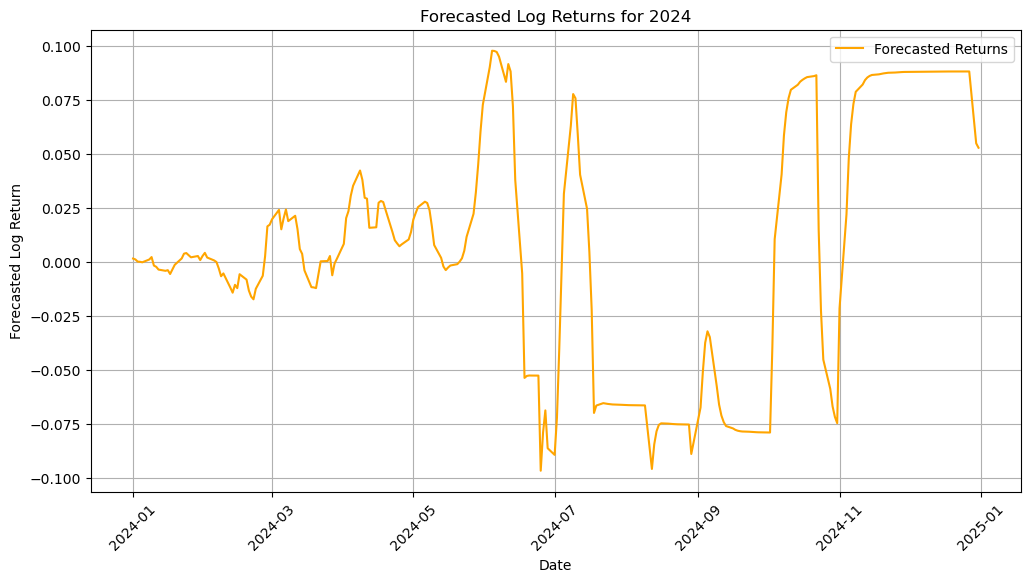

Processing SOXX...


[*********************100%***********************]  1 of 1 completed


Price           Close
Date                 
2001-07-13  20.047237
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.00011399720128020446), ('fit_intercept', False), ('max_iter', 1016), ('precompute', False), ('tol', 0.00954949407092657)])
Computation Time: 100.73 seconds
Train RMSE: 0.4723, Train MAE: 0.2968, Train MASE : 0.9388 
Test RMSE: 0.6238, Test MAE: 0.3726, Test MASE: 0.8771 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001099
2024-01-02               0.000218
2024-01-03               0.000111
2024-01-04              -0.000721
2024-01-05               0.002022
2024-01-08               0.000482
2024-01-09               0.001968
2024-01-10              -0.001947
2024-01-11              -0.001630
2024-01-12              -0.004033
2024-01-15              -0.006290
2024-01-16              -0.004777
2024-01-17              -0.006394
2024-01-18              -0.003725
2024-01-19              -0.002295
2024-

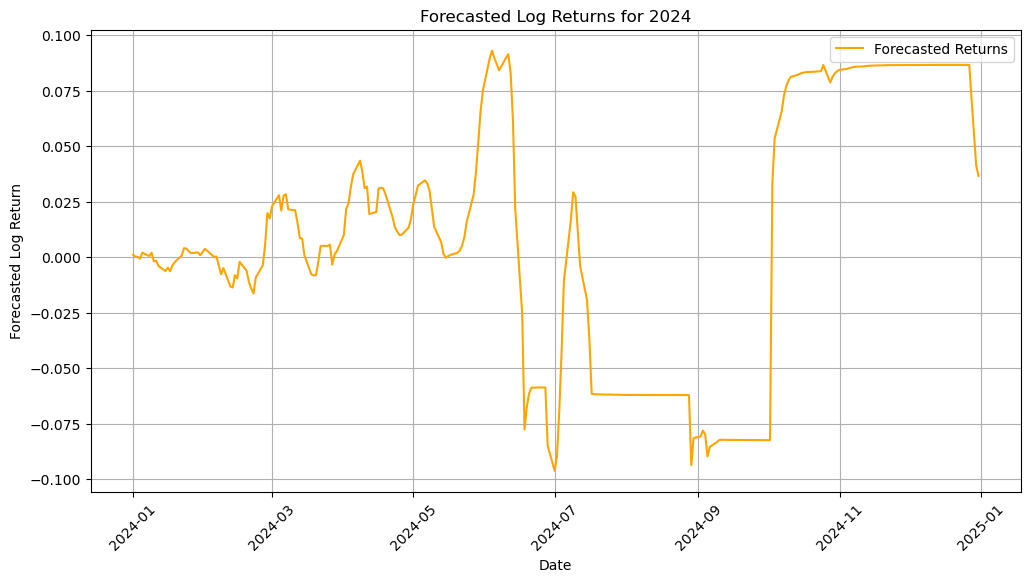

Processing PSI...


[*********************100%***********************]  1 of 1 completed


Price          Close
Date                
2005-06-23  4.565937
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.00011399720128020446), ('fit_intercept', False), ('max_iter', 1016), ('precompute', False), ('tol', 0.00954949407092657)])
Computation Time: 83.96 seconds
Train RMSE: 0.4815, Train MAE: 0.3070, Train MASE : 0.9223 
Test RMSE: 0.7524, Test MAE: 0.4471, Test MASE: 0.8632 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000990
2024-01-02               0.000640
2024-01-03               0.000279
2024-01-04              -0.002082
2024-01-05              -0.000186
2024-01-08              -0.000399
2024-01-09               0.001551
2024-01-10              -0.002401
2024-01-11              -0.003284
2024-01-12              -0.003824
2024-01-15              -0.007130
2024-01-16              -0.005513
2024-01-17              -0.004732
2024-01-18              -0.003474
2024-01-19               0.000156
2024-01-2

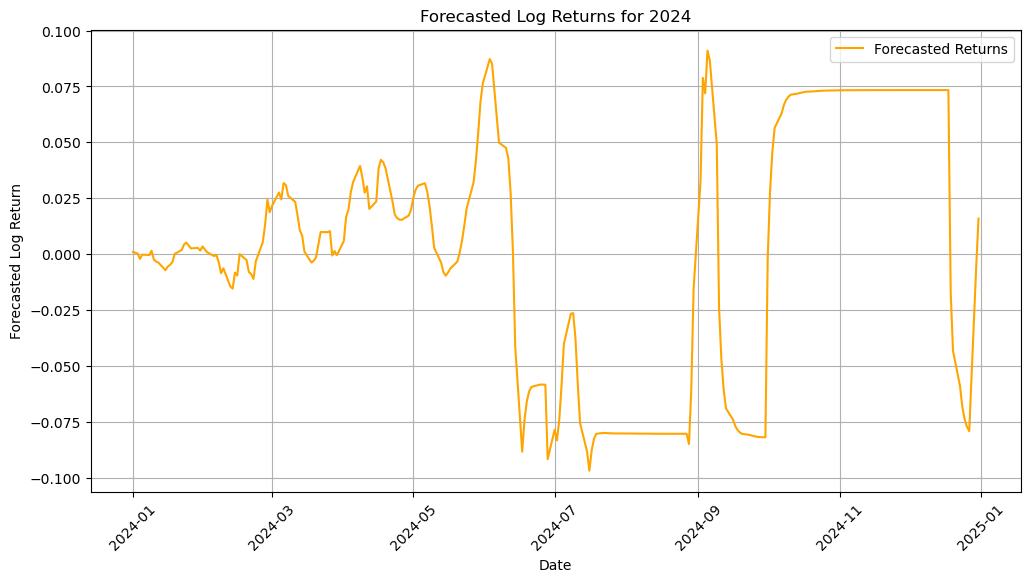

Processing XSD...


[*********************100%***********************]  1 of 1 completed


Price           Close
Date                 
2006-02-06  23.976191
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.0003812711108538731), ('fit_intercept', False), ('max_iter', 3344), ('precompute', 'auto'), ('tol', 0.009713042561594594)])
Computation Time: 88.51 seconds
Train RMSE: 0.4835, Train MAE: 0.3070, Train MASE : 0.9272 
Test RMSE: 0.7393, Test MAE: 0.4539, Test MASE: 0.8599 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000314
2024-01-02              -0.000421
2024-01-03              -0.000054
2024-01-04              -0.002204
2024-01-05              -0.001507
2024-01-08              -0.001118
2024-01-09               0.001038
2024-01-10              -0.003460
2024-01-11              -0.003035
2024-01-12              -0.006314
2024-01-15              -0.007962
2024-01-16              -0.006718
2024-01-17              -0.005056
2024-01-18              -0.005073
2024-01-19              -0.001034
2024-

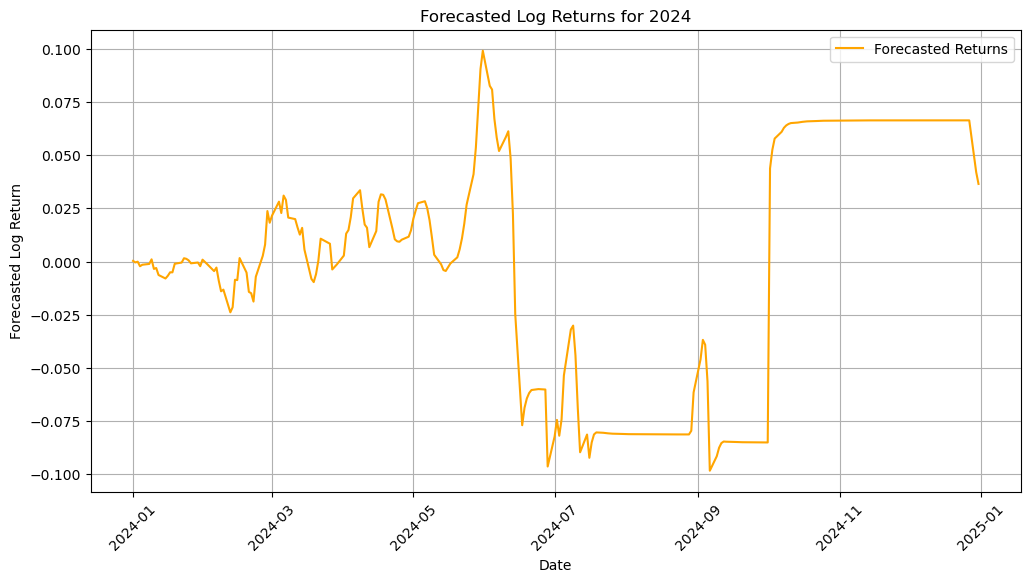

Processing IYW...


[*********************100%***********************]  1 of 1 completed


Price          Close
Date                
2000-05-19  23.65004
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.006104724980404096), ('fit_intercept', False), ('max_iter', 1000), ('precompute', 'auto'), ('tol', 0.01)])
Computation Time: 106.51 seconds
Train RMSE: 0.4911, Train MAE: 0.2808, Train MASE : 0.9498 
Test RMSE: 0.5575, Test MAE: 0.3254, Test MASE: 0.8893 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001267
2024-01-02               0.000830
2024-01-03               0.000877
2024-01-04               0.000487
2024-01-05              -0.001461
2024-01-08               0.000100
2024-01-09               0.000572
2024-01-10              -0.001546
2024-01-11              -0.001649
2024-01-12              -0.000756
2024-01-15              -0.001113
2024-01-16              -0.002011
2024-01-17              -0.003516
2024-01-18              -0.002211
2024-01-19              -0.001343
2024-01-22              

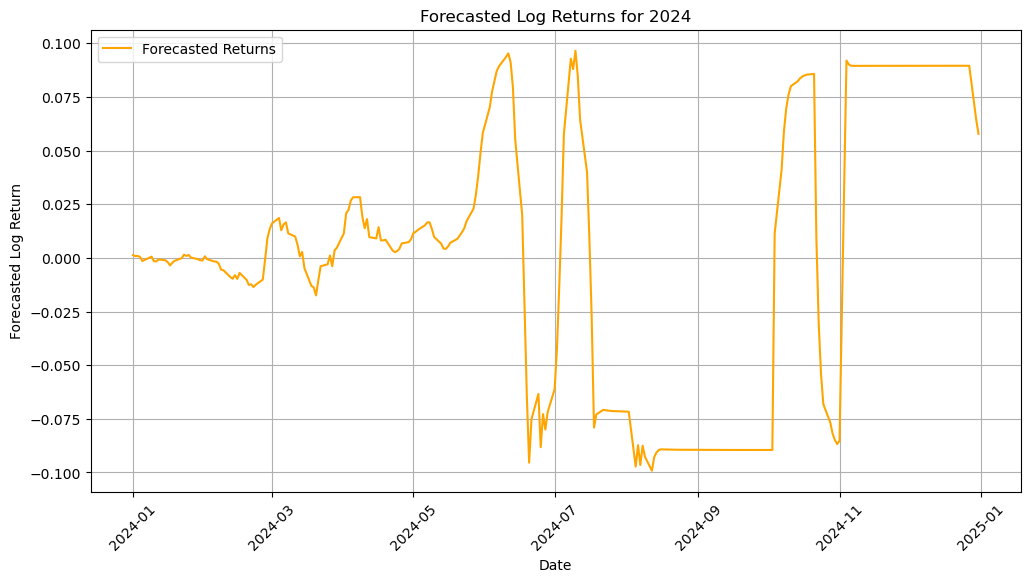

Processing XLK...


[*********************100%***********************]  1 of 1 completed


Price           Close
Date                 
2000-01-03  41.561359
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.007662562904976949), ('fit_intercept', True), ('max_iter', 1380), ('precompute', False), ('tol', 0.008448804877279796)])
Computation Time: 122.72 seconds
Train RMSE: 0.4755, Train MAE: 0.2732, Train MASE : 0.9425 
Test RMSE: 0.5892, Test MAE: 0.3410, Test MASE: 0.8879 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001393
2024-01-02               0.001224
2024-01-03               0.000757
2024-01-04              -0.000632
2024-01-05              -0.000067
2024-01-08               0.000741
2024-01-09               0.000782
2024-01-10              -0.001048
2024-01-11              -0.001318
2024-01-12              -0.000986
2024-01-15              -0.001255
2024-01-16              -0.002183
2024-01-17              -0.003847
2024-01-18              -0.002240
2024-01-19              -0.001084
2024-01

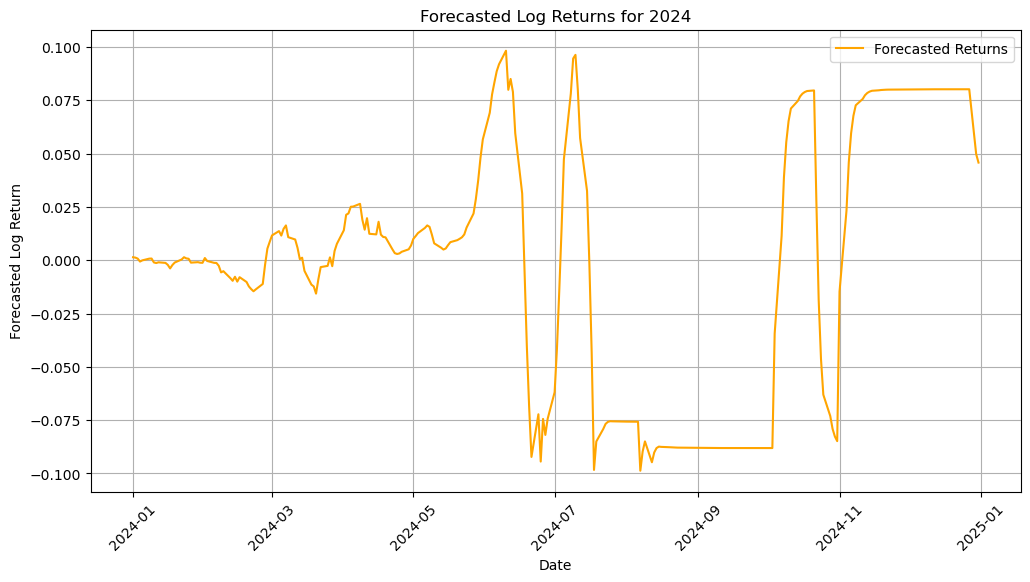

Processing VGT...


[*********************100%***********************]  1 of 1 completed


Price           Close
Date                 
2004-01-30  41.257465
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.0061923826753282705), ('fit_intercept', False), ('max_iter', 4000), ('precompute', False), ('tol', 0.01)])
Computation Time: 104.40 seconds
Train RMSE: 0.4682, Train MAE: 0.2832, Train MASE : 0.9281 
Test RMSE: 0.7436, Test MAE: 0.4236, Test MASE: 0.8696 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000843
2024-01-02               0.000663
2024-01-03              -0.000105
2024-01-04               0.000545
2024-01-05               0.000792
2024-01-08               0.000122
2024-01-09               0.001003
2024-01-10              -0.001199
2024-01-11              -0.001725
2024-01-12              -0.000458
2024-01-15              -0.001628
2024-01-16              -0.002578
2024-01-17              -0.002867
2024-01-18              -0.000620
2024-01-19              -0.001492
2024-01-22           

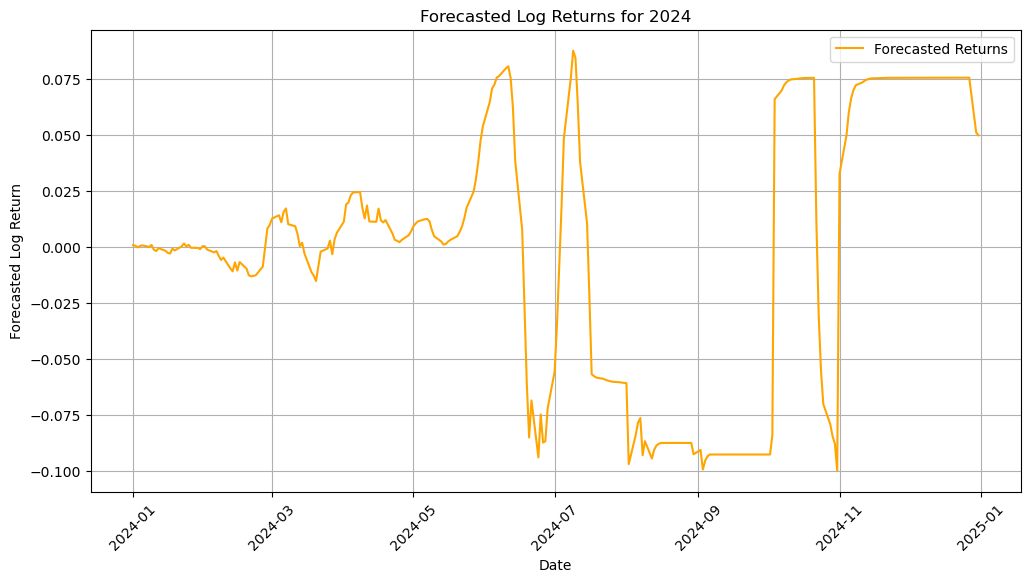

Processing QQQ...


[*********************100%***********************]  1 of 1 completed


Price           Close
Date                 
2000-01-03  80.434113
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.005848231717809338), ('fit_intercept', False), ('max_iter', 4000), ('precompute', 'auto'), ('tol', 0.01)])
Computation Time: 113.92 seconds
Train RMSE: 0.4703, Train MAE: 0.2686, Train MASE : 0.9496 
Test RMSE: 0.5070, Test MAE: 0.2980, Test MASE: 0.8934 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.001172
2024-01-02               0.001020
2024-01-03               0.000448
2024-01-04               0.000040
2024-01-05              -0.000759
2024-01-08               0.000242
2024-01-09               0.000388
2024-01-10              -0.001056
2024-01-11              -0.001612
2024-01-12              -0.000775
2024-01-15              -0.001766
2024-01-16              -0.002631
2024-01-17              -0.003411
2024-01-18              -0.002157
2024-01-19              -0.000290
2024-01-22           

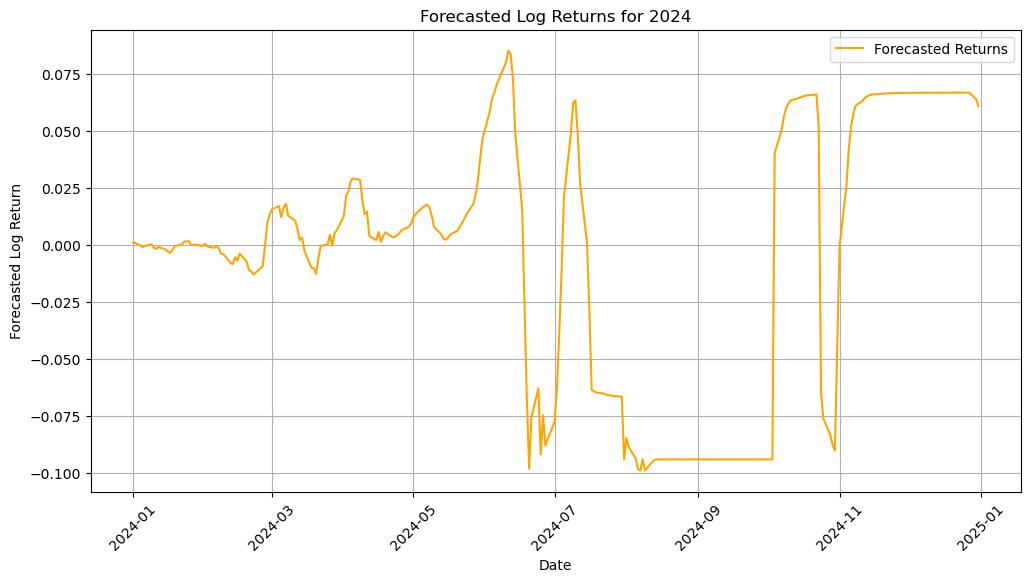

Processing IGM...


[*********************100%***********************]  1 of 1 completed


Price          Close
Date                
2001-03-19  7.938023
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.0001552451510898873), ('fit_intercept', False), ('max_iter', 1000), ('precompute', 'auto'), ('tol', 0.01)])
Computation Time: 135.10 seconds
Train RMSE: 0.4548, Train MAE: 0.2757, Train MASE : 0.9452 
Test RMSE: 0.6179, Test MAE: 0.3508, Test MASE: 0.8999 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000921
2024-01-02               0.000623
2024-01-03              -0.000305
2024-01-04              -0.000592
2024-01-05               0.001292
2024-01-08              -0.000386
2024-01-09               0.000154
2024-01-10              -0.001880
2024-01-11              -0.001326
2024-01-12              -0.001569
2024-01-15              -0.001863
2024-01-16              -0.002472
2024-01-17              -0.003687
2024-01-18              -0.001466
2024-01-19              -0.002257
2024-01-22             

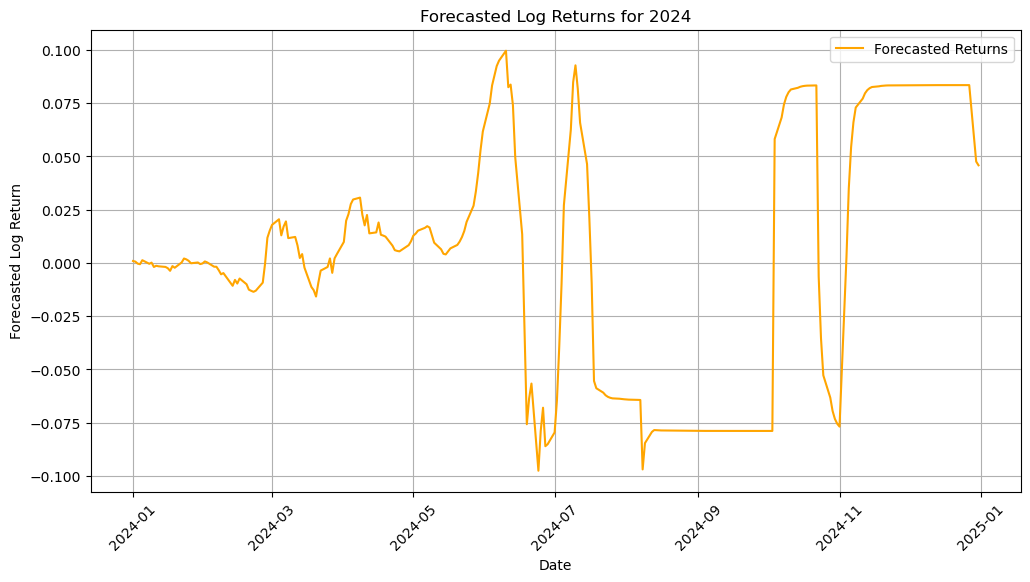

Processing IXN...


[*********************100%***********************]  1 of 1 completed


Price          Close
Date                
2001-11-26  7.813634
Index(['Close'], dtype='object', name='Price')
Best Model Parameters:
OrderedDict([('eps', 0.005499208626396953), ('fit_intercept', False), ('max_iter', 4000), ('precompute', 'auto'), ('tol', 0.01)])
Computation Time: 91.51 seconds
Train RMSE: 0.4597, Train MAE: 0.2757, Train MASE : 0.9322 
Test RMSE: 0.6652, Test MAE: 0.3792, Test MASE: 0.8932 
Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000632
2024-01-02               0.000454
2024-01-03               0.000225
2024-01-04              -0.000056
2024-01-05               0.000863
2024-01-08               0.000335
2024-01-09               0.000743
2024-01-10              -0.000472
2024-01-11              -0.001004
2024-01-12              -0.000250
2024-01-15              -0.001253
2024-01-16              -0.002123
2024-01-17              -0.002548
2024-01-18              -0.001157
2024-01-19              -0.000849
2024-01-22               

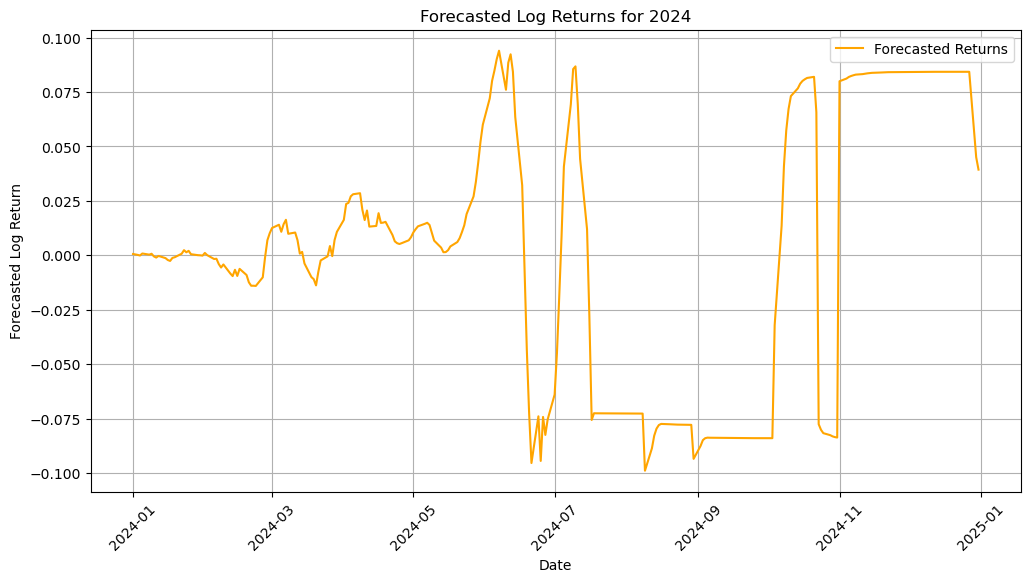

In [9]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31", auto_adjust=True)
        data.columns = data.columns.get_level_values(0)
        data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        print(data.head(1))
        print(data.columns
             )
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        plot_forecasted_returns(future_predictions)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2024)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

#tickers = ['SMH', 'SOXX', 'PSI',]

#tickers = ['SMH', 'SOXX', 'PSI','XSD', 'IYW', 'XLK', 'VGT',]

# Execute the workflow for multiple tickers
results = run_workflow(tickers)


In [10]:
#formatted_dict = {f"forecast_predictions_df_{i+1}": values for i, values in enumerate(grouped_corrected_data.values())}

#formatted_dict

Overall mean Training MAE: 0.285242
Overall mean Test MAE: 0.372265
Overall mean Training RMSE: 0.472915
Overall mean Test RMSE: 0.634134
Overall mean Training MASE: 0.938117
Overall mean Test MASE: 0.879758
Total time elapsed to run the model: 1052.217442 seconds
Average time consumed by model to train on an ETF: 105.22 seconds


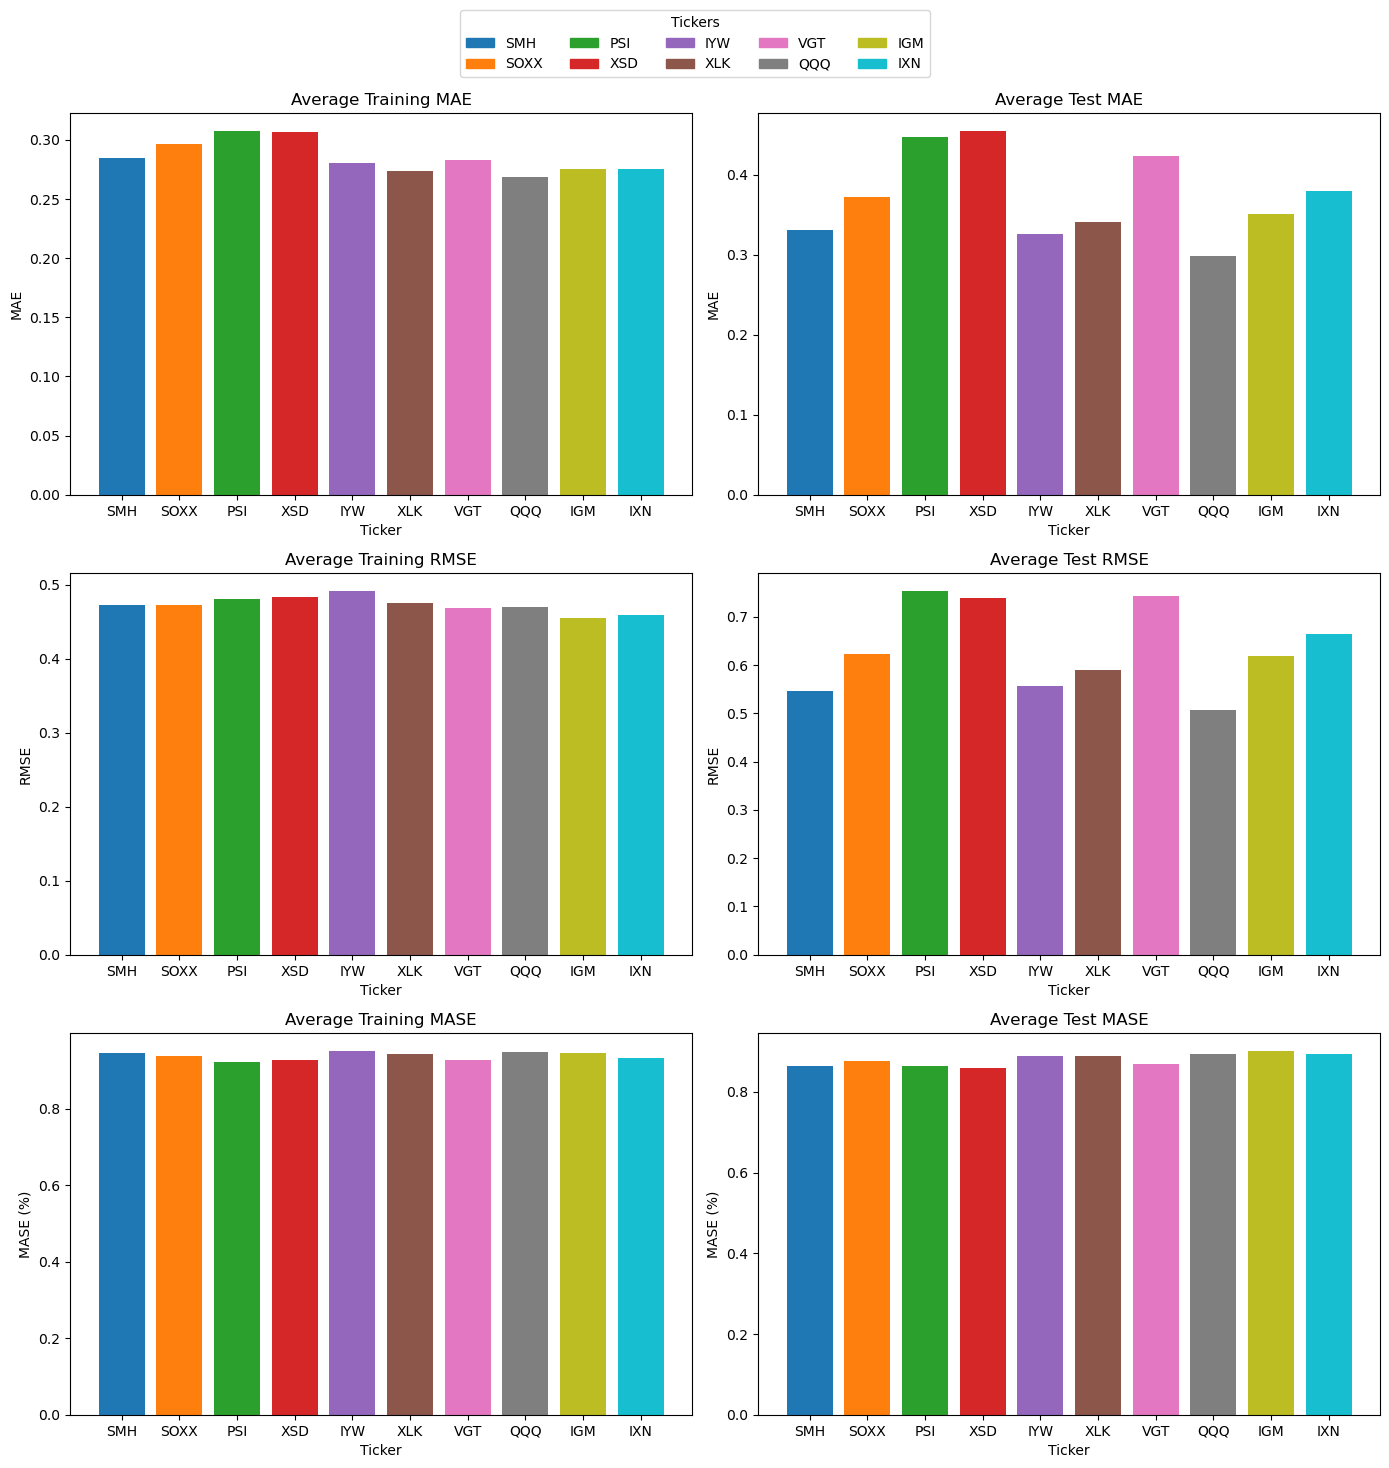

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

def plot_model_metrics(tickers, results):
    """
    Plots model performance metrics (MAE, RMSE, and MASE) for training and test sets.
    
    Parameters:
    - tickers: List of tickers.
    - results: Dictionary containing model metrics for each ticker.
    """
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []
    avg_training_mase = []
    avg_test_mase = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))
        avg_training_mase.append(train_set.get("mase", float('nan')))
        avg_test_mase.append(test_set.get("mase", float('nan')))

        computation_time.append(model_metrics.get("time", float('nan'))) 
    
    # Print global averages
    print(f"Overall mean Training MAE: {mean(avg_training_mae):.6f}")
    print(f"Overall mean Test MAE: {mean(avg_test_mae):.6f}")
    print(f"Overall mean Training RMSE: {mean(avg_training_rmse):.6f}")
    print(f"Overall mean Test RMSE: {mean(avg_test_rmse):.6f}")
    print(f"Overall mean Training MASE: {mean(avg_training_mase):.6f}")
    print(f"Overall mean Test MASE: {mean(avg_test_mase):.6f}")
    print(f"Total time elapsed to run the model: {sum(computation_time):.6f} seconds")
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds")

    # --- 2. Define a color palette ---
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # --- 3. Set up a 3×2 subplot grid ---
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 5: Average Training MASE ---
    ax = axs[2, 0]
    ax.bar(x_positions, avg_training_mase, color=colors[:len(tickers)])
    ax.set_title("Average Training MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE (%)")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 6: Average Test MASE ---
    ax = axs[2, 1]
    ax.bar(x_positions, avg_test_mase, color=colors[:len(tickers)])
    ax.set_title("Average Test MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE (%)")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))
    )

    plt.show()

plot_model_metrics(tickers, results)

In [12]:
def calculate_sharpe_ratio(returns, risk_free_rate_annual=0.1):
    """
    Diagnostic Sharpe Ratio function to print intermediate steps and identify issues.
    
    Parameters:
    - returns (numpy array or list): Array of daily log returns (already partitioned).
    - risk_free_rate_annual (float): Annualized risk-free rate. Default is 3% (0.03).
    
    Returns:
    - sharpe_ratio (float): The Sharpe Ratio.
    """
    # Convert list to numpy array if necessary
    returns = np.array(returns)
    
    # Adjust risk-free rate for daily frequency
    risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / 252) - 1
    
    # Calculate excess returns using daily risk-free rate
    excess_returns = returns - risk_free_rate_daily
    
    # Calculate mean of excess returns
    mean_excess_return = np.mean(excess_returns)
    
    # Calculate unbiased standard deviation using the corrected formula
    k = len(returns)
    mean_return = np.mean(returns)
    
    # Using the alternative unbiased standard deviation formula from the image
    variance = (np.sum(returns**2) / (k - 1)) - (k / (k - 1)) * (mean_return**2)
    std_dev = np.sqrt(variance) if variance > 0 else 0  # Avoid negative sqrt
    
    # **Adjust standard deviation for annualization** (scaling by sqrt(252))
    adjusted_std_dev = std_dev * np.sqrt(252)
    
   
    # Calculate Sharpe Ratio using adjusted standard deviation
    sharpe_ratio = mean_excess_return / adjusted_std_dev if adjusted_std_dev != 0 else 0  # Avoid division by zero
    
    return sharpe_ratio

def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95, epsilon=1e-6):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES) for the left tail (worst-case scenarios)
    if np.any(sorted_returns <= lower_threshold):
        es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    else:
        es = 0  # To handle cases where no returns fall in the left tail
    
    # Step 4: Calculate Expected Gain (EG) for the right tail (best-case scenarios)
    if np.any(sorted_returns >= upper_threshold):
        eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    else:
        eg = 0  # To handle cases where no returns fall in the right tail
    
    # Step 5: Compute the Rachev Ratio with epsilon to prevent division by zero
    es = abs(es) if es != 0 else epsilon  # Replace zero ES with epsilon
    rachev_ratio = eg / es  # No need for abs(es) since zero is replaced with epsilon
    
    return rachev_ratio


def calculate_volatility_clustering(returns, lag=1):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    
    # Handle empty input case
    if len(returns) == 0 or len(returns) <= lag:
        return None  # Return None if not enough data points

    abs_returns = np.abs(returns)  # Use absolute returns as per formula
    
     

    # Compute Pearson correlation between |r_t| and |r_{t+lag}|
    correlation_matrix = np.corrcoef(abs_returns[:-lag], abs_returns[lag:])
    clustering = correlation_matrix[0, 1]  # Extract correlation coefficient
    
    if np.isnan(clustering):
        return 0.0 
    return clustering


def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )

    epsilon = 1e-8

    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


In [13]:
import numpy as np
from scipy.optimize import minimize

def calculate_composite_score_optimized(
    forecasted_values, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)
    
    # Metrics in an array
    metrics = np.array([rachev_normalized, sharpe_normalized, sortino_normalized, -volatility_clustering_normalized])
    
    # Objective function: maximize risk-adjusted composite score
    def objective(weights):
        composite_score = np.dot(weights, metrics)  # Weighted sum
        risk = np.std(metrics * weights)  # Risk adjustment
        return -composite_score / (risk + epsilon)  # Negative for minimization
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: Each weight between 0 and 1
    bounds = [(0, 1) for _ in range(len(metrics))]
    
    # Initial equal weighting
    initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
    
    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    # Compute final optimized composite score
    optimized_score = np.dot(optimized_weights, metrics)
    
    return optimized_score, optimized_weights

def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = score
    
    return composite_scores


In [14]:
def scores_monthly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a monthly basis.
    Return a dictionary of all ETF scores per month.
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per month
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    months = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[month].get(ticker, None) for month in months] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(20, 8))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(months, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(months)), labels=months[::1], rotation=45)

    plt.title("Composite Scores for Tickers Over Months")
    plt.xlabel("Months (1-month intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_monthly(results, return_scores=False)



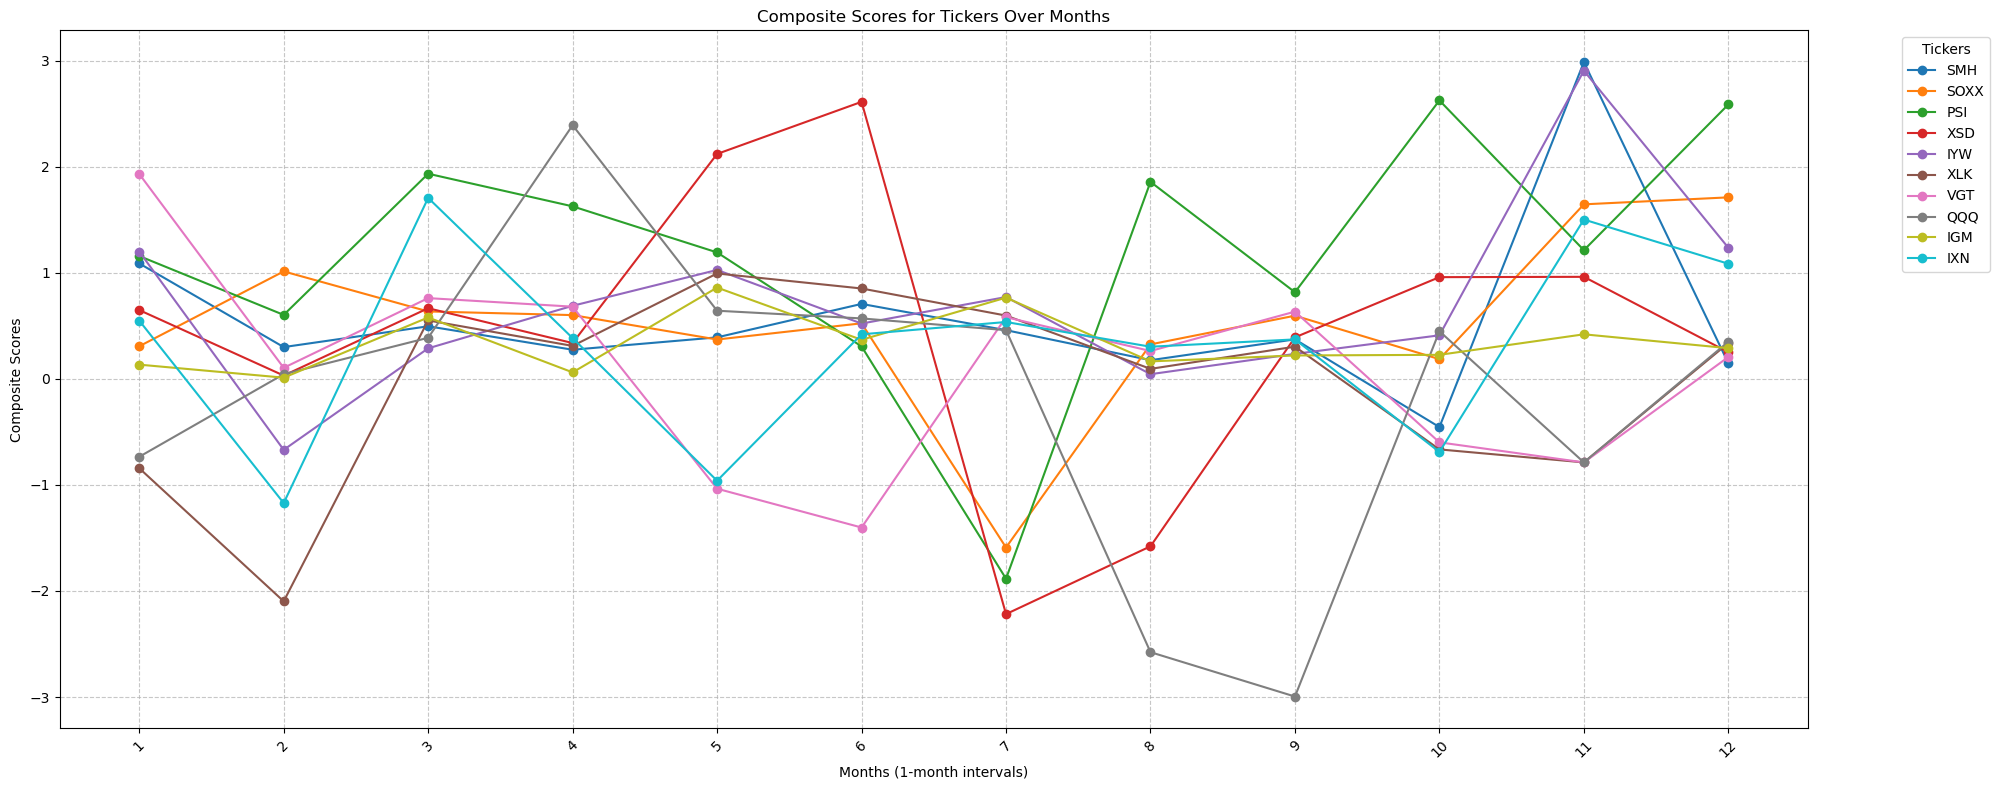

In [15]:
plot_composite_scores(scores, tickers)


In [16]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

In [17]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, smoothing=False):
    all_scores = portfolio(results, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            data.columns = data.columns.get_level_values(0)

            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [18]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 1.0880600804809837, 'SOXX': 0.3068962479238291, 'PSI': 1.1576200627423499, 'XSD': 0.6481611964858995, 'IYW': 1.1996745493600331, 'XLK': -0.8424772782989096, 'VGT': 1.9313161701934245, 'QQQ': -0.7348542829848218, 'IGM': 0.1338192134642907, 'IXN': 0.5489608237219319}
Month 2: {'SMH': 0.299225218451005, 'SOXX': 1.0128874194078703, 'PSI': 0.6026807270410522, 'XSD': 0.03074572970964908, 'IYW': -0.6693772895363196, 'XLK': -2.0974367134344347, 'VGT': 0.10389171917850253, 'QQQ': 0.04394310470392317, 'IGM': 0.011007988225443462, 'IXN': -1.1711098666855815}
Month 3: {'SMH': 0.4953642255494013, 'SOXX': 0.6353211596684658, 'PSI': 1.933649382624214, 'XSD': 0.6656341740997601, 'IYW': 0.28758152295873546, 'XLK': 0.5506916854393895, 'VGT': 0.7608444603931503, 'QQQ': 0.38696147115961743, 'IGM': 0.5785087067348594, 'IXN': 1.7055660273228928}
Month 4: {'SMH': 0.2743872313857634, 'SOXX': 0.600819253454312, 'PSI': 1.6260223740367383, 'XSD': 0.3372978234

[*********************100%***********************]  1 of 1 completed

Buy VGT: 106.51 shares at 468.25.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['VGT', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['VGT', 'PSI']
Sell IYW: 418.23 shares at 127.59. Total value: 53230.17
Buy PSI: 1075.26 shares at 49.38.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'VGT': 106.51310776697834, 'PSI': 1075.2570193001336}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['VGT', 'PSI']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['VGT', 'PSI']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'VGT': 106.51310776697834, 'PSI': 1075.2570193001336}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['VGT', 'PSI']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['VGT', 'PSI']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'VGT': 106.51310776697834, 'PSI': 1075.2570193001336}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['VGT', 'PSI']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['VGT', 'PSI']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'VGT': 106.


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 134341.42


In [19]:

portfolios, final_value = portfolio_optimization(results,smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 1.0880600804809837, 'SOXX': 0.3068962479238291, 'PSI': 1.1576200627423499, 'XSD': 0.6481611964858995, 'IYW': 1.1996745493600331, 'XLK': -0.8424772782989096, 'VGT': 1.9313161701934245, 'QQQ': -0.7348542829848218, 'IGM': 0.1338192134642907, 'IXN': 0.5489608237219319}
Month 2: {'SMH': 0.299225218451005, 'SOXX': 1.0128874194078703, 'PSI': 0.6026807270410522, 'XSD': 0.03074572970964908, 'IYW': -0.6693772895363196, 'XLK': -2.0974367134344347, 'VGT': 0.10389171917850253, 'QQQ': 0.04394310470392317, 'IGM': 0.011007988225443462, 'IXN': -1.1711098666855815}
Month 3: {'SMH': 0.4953642255494013, 'SOXX': 0.6353211596684658, 'PSI': 1.933649382624214, 'XSD': 0.6656341740997601, 'IYW': 0.28758152295873546, 'XLK': 0.5506916854393895, 'VGT': 0.7608444603931503, 'QQQ': 0.38696147115961743, 'IGM': 0.5785087067348594, 'IXN': 1.7055660273228928}
Month 4: {'SMH': 0.2743872313857634, 'SOXX': 0.600819253454312, 'PSI': 1.6260223740367383, 'XSD': 0.3372978234

[*********************100%***********************]  1 of 1 completed

Buy VGT: 106.51 shares at 468.25.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['VGT', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['SOXX', 'PSI']
Sell VGT: 106.51 shares at 497.06. Total value: 52810.55
Sell IYW: 418.23 shares at 127.59. Total value: 53230.17
Buy SOXX: 270.03 shares at 195.08.
Buy PSI: 1075.26 shares at 49.38.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'SOXX': 270.0309068225631, 'PSI': 1075.256955005385}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['SOXX', 'PSI']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['PSI', 'IXN']
Sell SOXX: 270.03 shares at 225.19. Total value: 60656.14
Buy IXN: 812.48 shares at 74.47.
Updated ticker shares after 2024-03-01 to 2024-03-31: {'PSI': 1075.256955005385, 'IXN': 812.4842834459319}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['PSI', 'IXN']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['QQQ', 'PSI']
Sell IXN: 812.48 shares at 74.73. Total value: 60563.05
Buy QQQ: 136.40 shares at 442.91.
Updated ticker 


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 129540.14


In [20]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results
###
def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }

        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = score
    
    return composite_scores


In [21]:
def scores_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week
import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    weeks = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[week].get(ticker, None) for week in weeks] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(30, 14))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(weeks, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(weeks), 4), labels=weeks[::4], rotation=45)

    plt.title("Composite Scoares for Tickers Over Weeks")
    plt.xlabel("Weeks (4-week intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_weekly(results,return_scores=False)



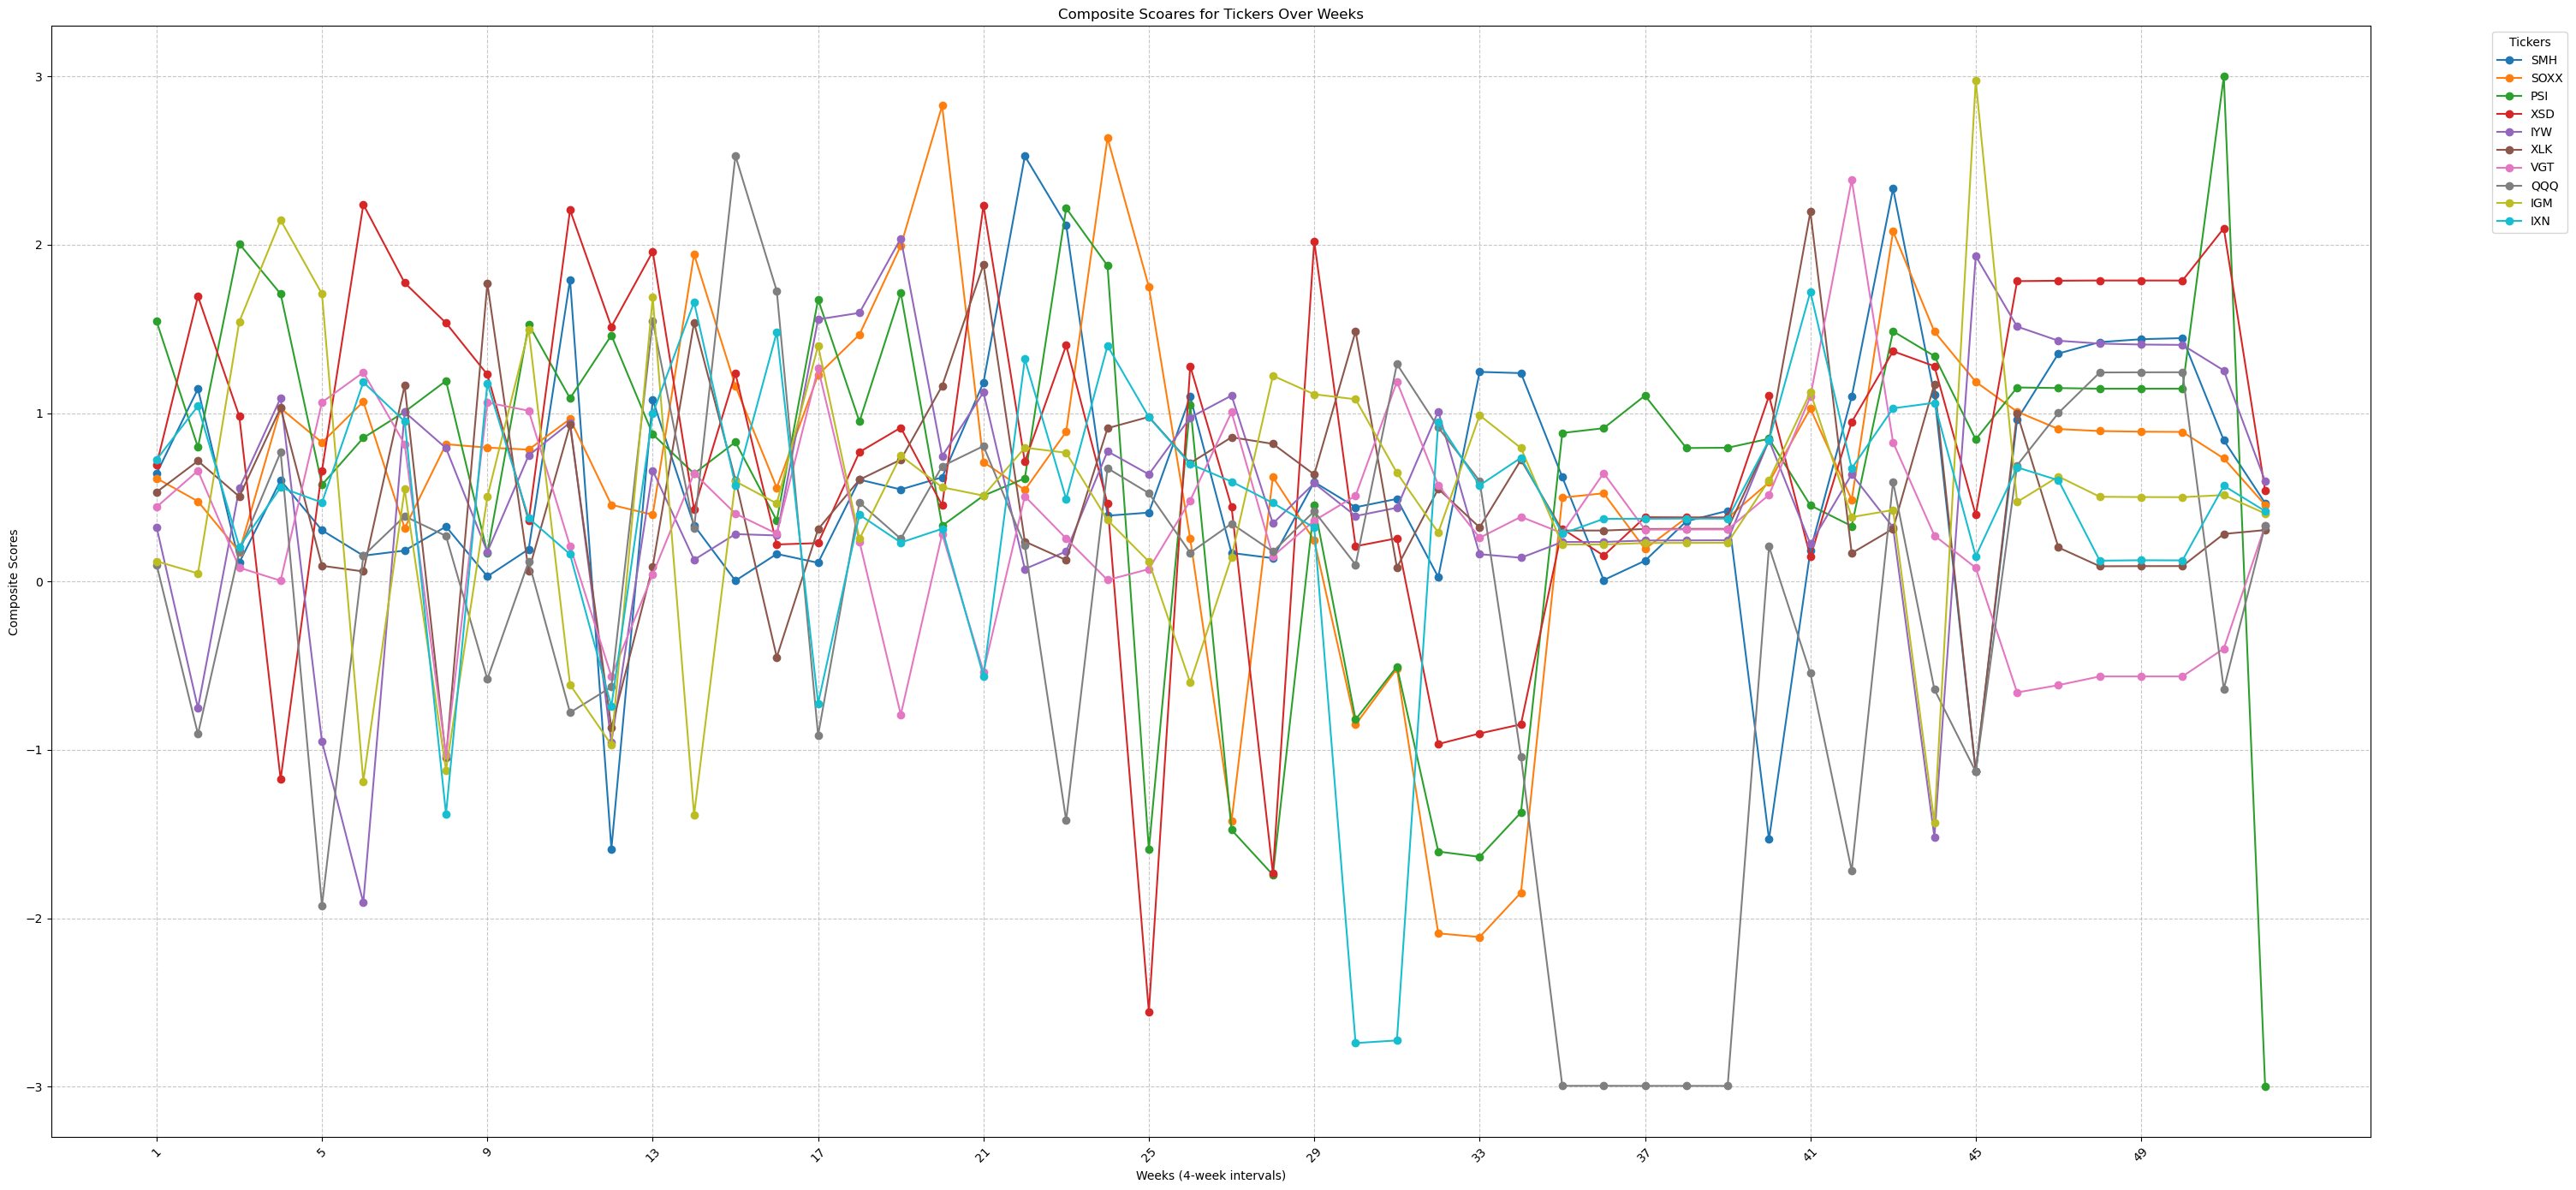

In [22]:
plot_composite_scores(scores, tickers)


In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            data.columns = data.columns.get_level_values(0)

            
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [25]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.6419664683506079, 'SOXX': 0.613478679761095, 'PSI': 1.5452955621493394, 'XSD': 0.6948138217151262, 'IYW': 0.32328659338846055, 'XLK': 0.5313112794395553, 'VGT': 0.4431014293509794, 'QQQ': 0.10063206522368683, 'IGM': 0.12064096472735401, 'IXN': 0.724859075168018}
Week 2: {'SMH': 1.1447881598427272, 'SOXX': 0.4764131122019142, 'PSI': 0.7977500503922117, 'XSD': 1.6943525400819837, 'IYW': -0.7516800020257983, 'XLK': 0.716460066239186, 'VGT': 0.6584230847316861, 'QQQ': -0.9057635477426277, 'IGM': 0.0483772557800055, 'IXN': 1.042328529723807}
Week 3: {'SMH': 0.11271223931811775, 'SOXX': 0.17665499925018563, 'PSI': 2.0060249035706574, 'XSD': 0.9825163628965339, 'IYW': 0.5535303548359554, 'XLK': 0.5048393894185753, 'VGT': 0.08257910297550887, 'QQQ': 0.17924203948127757, 'IGM': 1.5434687843739179, 'IXN': 0.2064962045235155}
Week 4: {'SMH': 0.6013573805372137, 'SOXX': 1.0291760315926106, 'PSI': 1.7084183211734638, 'XSD': -1.1749732820492815,

Buy PSI: 1046.84 shares at 47.64.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['PSI', 'IXN']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['PSI', 'XSD']
Sell IXN: 755.40 shares at 66.48. Total value: 50095.44
Buy XSD: 232.91 shares at 214.54.
Updated ticker shares after 2024-01-08 to 2024-01-14: {'PSI': 1046.8424498923007, 'XSD': 232.9129312051038}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['PSI', 'XSD']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['PSI', 'XSD']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'PSI': 1046.8424498923007, 'XSD': 232.9129312051038}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['PSI', 'XSD']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['PSI', 'IXN']
Sell XSD: 232.91 shares at 224.21. Total value: 52091.89
Buy IXN: 737.51 shares at 70.46.
Updated ticker shares after 2024-01-22 to 2024-01-28: {'PSI': 1046.8424498923007, 'IXN': 737.5067483287114}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['PSI', 'IXN']
Top 2 ETFs for 2024-01-29 to 2024-02-

Final Portfolio Value: 125345.76


In [26]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.6419664683506079, 'SOXX': 0.613478679761095, 'PSI': 1.5452955621493394, 'XSD': 0.6948138217151262, 'IYW': 0.32328659338846055, 'XLK': 0.5313112794395553, 'VGT': 0.4431014293509794, 'QQQ': 0.10063206522368683, 'IGM': 0.12064096472735401, 'IXN': 0.724859075168018}
Week 2: {'SMH': 1.1447881598427272, 'SOXX': 0.4764131122019142, 'PSI': 0.7977500503922117, 'XSD': 1.6943525400819837, 'IYW': -0.7516800020257983, 'XLK': 0.716460066239186, 'VGT': 0.6584230847316861, 'QQQ': -0.9057635477426277, 'IGM': 0.0483772557800055, 'IXN': 1.042328529723807}
Week 3: {'SMH': 0.11271223931811775, 'SOXX': 0.17665499925018563, 'PSI': 2.0060249035706574, 'XSD': 0.9825163628965339, 'IYW': 0.5535303548359554, 'XLK': 0.5048393894185753, 'VGT': 0.08257910297550887, 'QQQ': 0.17924203948127757, 'IGM': 1.5434687843739179, 'IXN': 0.2064962045235155}
Week 4: {'SMH': 0.6013573805372137, 'SOXX': 1.0291760315926106, 'PSI': 1.7084183211734638, 'XSD': -1.1749732820492815,

Buy PSI: 1046.84 shares at 47.64.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['PSI', 'IXN']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['XSD', 'SMH']
Sell IXN: 755.40 shares at 66.48. Total value: 50095.44
Sell PSI: 1046.84 shares at 47.21. Total value: 49301.92
Buy XSD: 232.91 shares at 214.54.
Buy SMH: 287.26 shares at 171.20.
Updated ticker shares after 2024-01-08 to 2024-01-14: {'XSD': 232.9129312051038, 'SMH': 287.2565450750392}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['XSD', 'SMH']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['PSI', 'IGM']
Sell XSD: 232.91 shares at 209.91. Total value: 48769.50
Sell SMH: 287.26 shares at 174.92. Total value: 50122.64
Buy IGM: 646.30 shares at 75.27.
Buy PSI: 1049.41 shares at 47.64.
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 646.2954881134269, 'PSI': 1049.4101384799103}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['PSI', 'IGM']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'PSI']
Updated ticker share

Final Portfolio Value: 109961.89
